In [ ]:
import os
os.environ['HADOOP_HOME'] = 'C:\\hadoop-3.3.6' # Change for other configuration, for mine it is installed as is

from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

spark = (SparkSession.builder
         .appName("model-comparison")
         .config("spark.driver.memory", "4g")
         .config("spark.executor.memory", "4g")
         .config("spark.sql.execution.arrow.pyspark.enabled", "true")
         .getOrCreate())
spark

## 1. Chargement des données test

In [2]:
test_df = spark.read.parquet("../dataset/processed/test")
test_df = test_df.withColumn("classWeightCol", F.lit(1.0))
print(f"Test samples: {test_df.count()}")
test_df.groupBy("Class").count().show()

Test samples: 56410
+-----+-----+
|Class|count|
+-----+-----+
|    1|   86|
|    0|56324|
+-----+-----+

+-----+-----+
|Class|count|
+-----+-----+
|    1|   86|
|    0|56324|
+-----+-----+



## 2. Chargement des modèles et métriques

In [3]:
models = {
    "LogisticRegression": PipelineModel.load("../models/lr_pipeline"),
    "RandomForest": PipelineModel.load("../models/rf_pipeline"),
    "GradientBoostedTrees": PipelineModel.load("../models/gbt_pipeline")
}

metrics = {}
for name, path in [("LogisticRegression", "../models/metrics.json"),
                   ("RandomForest", "../models/metrics_rf.json"),
                   ("GradientBoostedTrees", "../models/metrics_gbt.json")]:
    with open(path, "r") as f:
        metrics[name] = json.load(f)

print("Métriques des modèles:")
for name, m in metrics.items():
    print(f"{name:25s} AUPRC={m['auprc']:.4f}  AUROC={m['auroc']:.4f}")

Métriques des modèles:
LogisticRegression        AUPRC=0.6835  AUROC=0.9759
RandomForest              AUPRC=0.8358  AUROC=0.9722
GradientBoostedTrees      AUPRC=0.8472  AUROC=0.9919


## 3. Prédictions et scores

In [4]:
# Extraire la probabilité en utilisant array_to_vector puis element_at
from pyspark.ml.functions import vector_to_array

predictions = {}
for name, model in models.items():
    print(f"Traitement du modèle {name}...")
    preds = model.transform(test_df)
    # Convertir le vecteur probability en array puis extraire l'élément 1 (classe 1)
    preds = preds.withColumn("prob_array", vector_to_array(F.col("probability")))
    preds = preds.withColumn("score", F.col("prob_array")[1])
    # Sélectionner et convertir
    df_subset = preds.select("Class", "score", "prediction")
    predictions[name] = df_subset.toPandas()
    print(f"{name}: {len(predictions[name])} prédictions")

Traitement du modèle LogisticRegression...
LogisticRegression: 56410 prédictions
Traitement du modèle RandomForest...
LogisticRegression: 56410 prédictions
Traitement du modèle RandomForest...
RandomForest: 56410 prédictions
Traitement du modèle GradientBoostedTrees...
RandomForest: 56410 prédictions
Traitement du modèle GradientBoostedTrees...
GradientBoostedTrees: 56410 prédictions
GradientBoostedTrees: 56410 prédictions


## 4. Courbe Precision-Recall

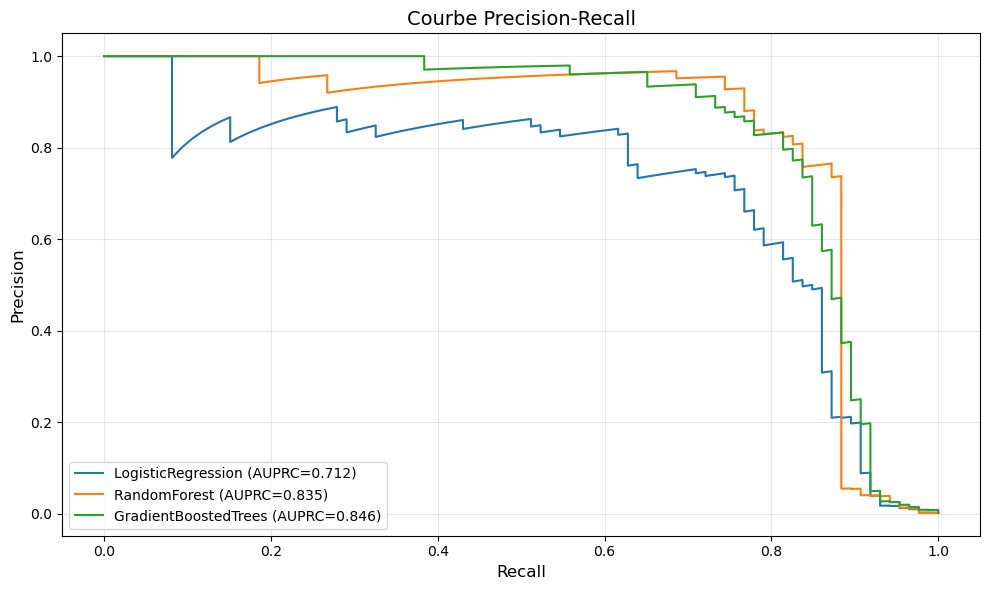

In [5]:
from sklearn.metrics import precision_recall_curve, auc

fig, ax = plt.subplots(figsize=(10, 6))
for name, pdf in predictions.items():
    precision, recall, thresholds = precision_recall_curve(pdf['Class'], pdf['score'])
    auprc = auc(recall, precision)
    ax.plot(recall, precision, label=f"{name} (AUPRC={auprc:.3f})")

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Courbe Precision-Recall', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Courbe ROC

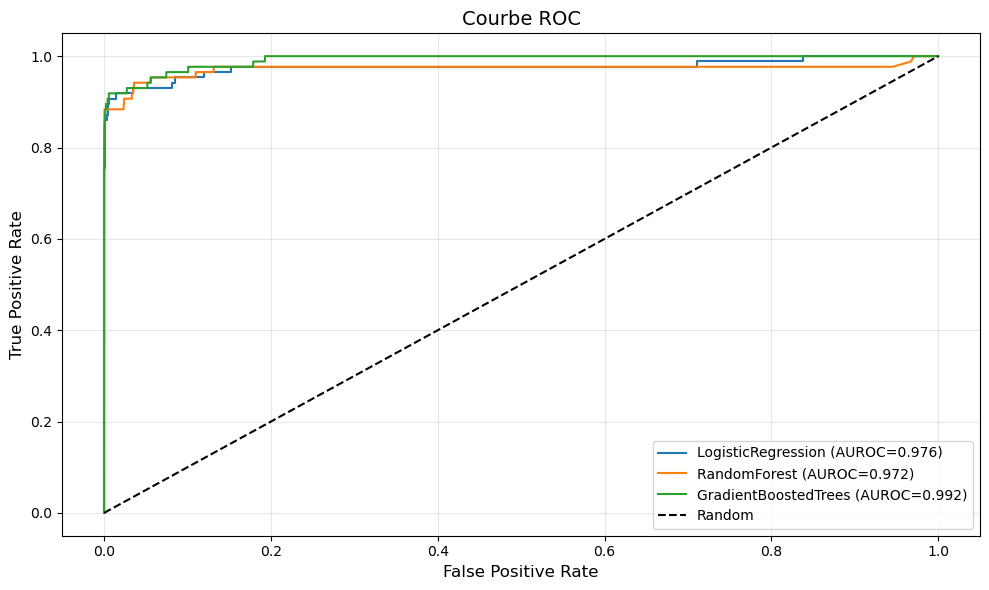

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score

fig, ax = plt.subplots(figsize=(10, 6))
for name, pdf in predictions.items():
    fpr, tpr, thresholds = roc_curve(pdf['Class'], pdf['score'])
    auroc = roc_auc_score(pdf['Class'], pdf['score'])
    ax.plot(fpr, tpr, label=f"{name} (AUROC={auroc:.3f})")

ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Courbe ROC', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Distribution des scores par classe

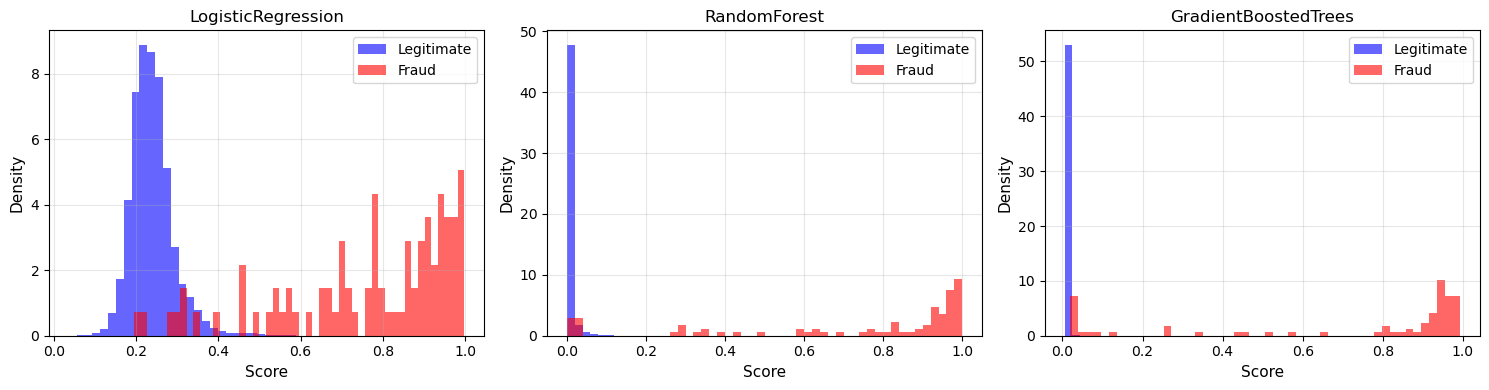

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, (name, pdf) in enumerate(predictions.items()):
    ax = axes[idx]
    legit = pdf[pdf['Class'] == 0]['score']
    fraud = pdf[pdf['Class'] == 1]['score']
    ax.hist(legit, bins=50, alpha=0.6, label='Legitimate', color='blue', density=True)
    ax.hist(fraud, bins=50, alpha=0.6, label='Fraud', color='red', density=True)
    ax.set_xlabel('Score', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(name, fontsize=12)
    ax.legend()
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Optimisation du seuil (meilleur modèle: GBT)

In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score

best_model = "GradientBoostedTrees"
pdf = predictions[best_model]
thresholds = np.linspace(0.1, 0.9, 50)
results = []

for thresh in thresholds:
    y_pred = (pdf['score'] >= thresh).astype(int)
    prec = precision_score(pdf['Class'], y_pred, zero_division=0)
    rec = recall_score(pdf['Class'], y_pred, zero_division=0)
    f1 = f1_score(pdf['Class'], y_pred, zero_division=0)
    results.append({'threshold': thresh, 'precision': prec, 'recall': rec, 'f1': f1})

res_df = pd.DataFrame(results)
best_f1_idx = res_df['f1'].idxmax()
best_thresh = res_df.loc[best_f1_idx, 'threshold']
print(f"Seuil optimal (F1 max): {best_thresh:.3f}")
print(res_df.loc[best_f1_idx])

Seuil optimal (F1 max): 0.231
threshold    0.230612
precision    0.833333
recall       0.813953
f1           0.823529
Name: 8, dtype: float64


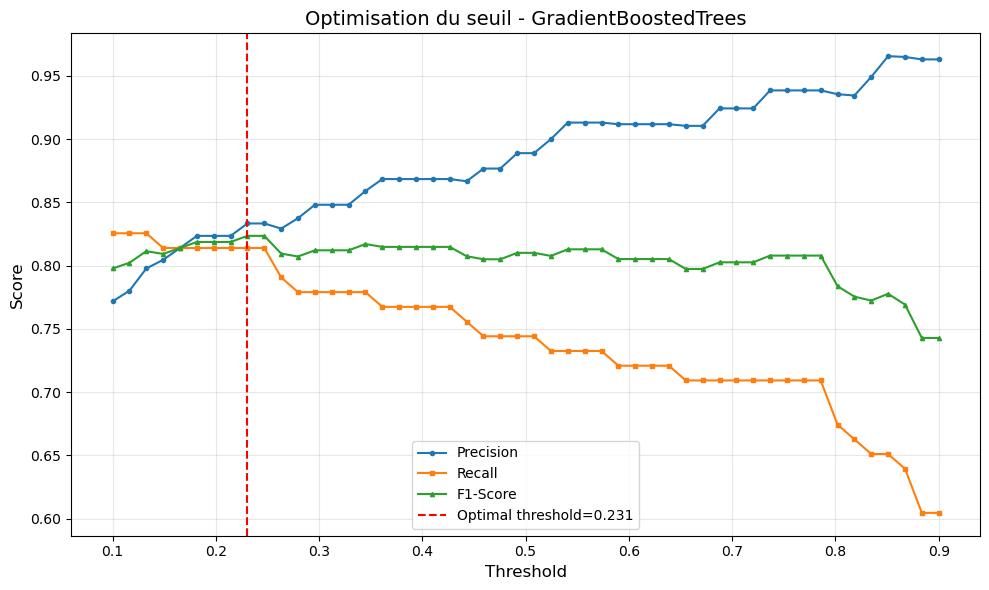

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(res_df['threshold'], res_df['precision'], label='Precision', marker='o', markersize=3)
ax.plot(res_df['threshold'], res_df['recall'], label='Recall', marker='s', markersize=3)
ax.plot(res_df['threshold'], res_df['f1'], label='F1-Score', marker='^', markersize=3)
ax.axvline(best_thresh, color='red', linestyle='--', label=f'Optimal threshold={best_thresh:.3f}')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title(f'Optimisation du seuil - {best_model}', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Matrice de confusion (seuil optimal)

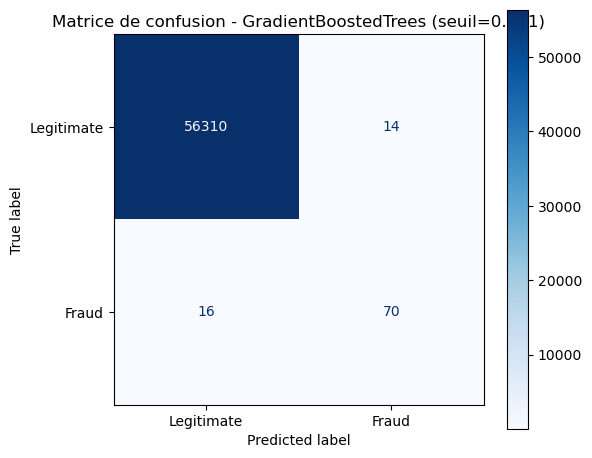

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_opt = (pdf['score'] >= best_thresh).astype(int)
cm = confusion_matrix(pdf['Class'], y_pred_opt)

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legitimate', 'Fraud'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title(f'Matrice de confusion - {best_model} (seuil={best_thresh:.3f})', fontsize=12)
plt.tight_layout()
plt.show()

## 9. Résumé final

In [11]:
summary = []
for name, m in metrics.items():
    summary.append({
        'Modèle': name,
        'AUPRC': f"{m['auprc']:.4f}",
        'AUROC': f"{m['auroc']:.4f}",
        'Train Frauds': m['train_counts']['1'],
        'Train Legit': m['train_counts']['0']
    })

summary_df = pd.DataFrame(summary)
print("\n=== Résumé des Modèles ===")
print(summary_df.to_string(index=False))
print(f"\nMeilleur modèle: {best_model}")
print(f"Seuil optimal: {best_thresh:.3f}")
print(f"F1-Score optimal: {res_df.loc[best_f1_idx, 'f1']:.4f}")


=== Résumé des Modèles ===
              Modèle  AUPRC  AUROC  Train Frauds  Train Legit
  LogisticRegression 0.6835 0.9759           387       226929
        RandomForest 0.8358 0.9722           387       226929
GradientBoostedTrees 0.8472 0.9919           387       226929

Meilleur modèle: GradientBoostedTrees
Seuil optimal: 0.231
F1-Score optimal: 0.8235
